In [2]:
import numpy as np
import scipy as sp
import scipy.special

params = {
    'a_min' : 75,
    'a_max' : 90,
    'b_min' : 500,
    'b_max' : 600,
    'p1' : 0.1,
    'p2' : 0.01,
    'p3' : 0.3
}

def p_uniform(a_min, a_max):
    return 1 / (a_max - a_min + 1)

def e(p, c):
    return p.dot(c)

def var(p, c):
    return e(p, c**2) - e(p, c)**2

def binomln(n, k):
    return sp.special.gammaln(n + 1) - sp.special.gammaln(k + 1) - sp.special.gammaln(n - k + 1)

In [3]:
import matplotlib.pyplot as plt
import time

%matplotlib inline

def run_modeling(generator, params, model, *args):
    start = time.time()
    p, c = generator(*args, params=params, model=model)
    end = time.time()

    print('Time elapsed {0}'.format(end - start))    
    print('E = {0}, Var = {1}'.format(e(p, c), var(p, c)))
    plt.plot(c, p)

For discrete uniform random variable X distributed in [a, b] we have:
$$ E(x) = \frac{b + a}{2} $$
$$ Var(x) = \frac{(b - a + 1)^2 - 1}{12} $$

So for random variables $a$ and $b$ have the following expectation values and variance:

E(a) = $ \frac{75 + 90}{2} = 82.5 $

Var(a) = $ \frac{(90 - 75 + 1)^2 - 1}{12} = 21.25 $ 

E(b) = $ \frac{500 + 600}{2} = 550 $

Var(b) = $ \frac{(600 - 500 + 1)^2 - 1}{12} = 850 $

In [4]:
for param in ['a', 'b']:
    p = p_uniform(params['{0}_min'.format(param)],
                  params['{0}_max'.format(param)]) * \
        np.ones(params['{0}_max'.format(param)] - params['{0}_min'.format(param)] + 1)
    c = np.arange(params['{0}_min'.format(param)], params['{0}_max'.format(param)] + 1)
    print('E({0}) = {1}, Var({0}) = {2}'.format(param, e(p, c), var(p, c)))

E(a) = 82.5, Var(a) = 21.25
E(b) = 550.0, Var(b) = 850.0


$$ p(c) = \sum_{a, b} p(c | a,b) p(a, b) $$

For the first model let us define $x_1 = Bin(a, p_1)$ and $x_2 = Bin(b, p_2)$, then

$$ p(c | a, b) = p(x_1 + x_2 = c| a,b) = \sum_{i = 0}^c Bin(i | ap_1)Bin(c - i|bp_2) $$

$$ p(c) = p(a,b) \frac{p_2}{1 - p_2}^c \sum_{x=0}^c \left(\frac{p_1(1 - p_2)}{p_2(1 - p_1)}\right)^x \sum_{a} \binom{a}{x} (1 - p_1)^a \sum_{b} \binom{b}{c - x}(1 - p_2)^b $$

For the second model we have:

$$ p(c | a, b) = Poison(ap_1 + bp_2) $$

In [5]:
import scipy as sp
import scipy.stats

def pc(params, model):
    try:
        golden_crutch[model]
    except NameError:
        global golden_crutch
        golden_crutch = {}
        golden_crutch[model] = pc__(model, **params)
    except KeyError:
        global golden_crutch
        golden_crutch[model] = pc__(model, **params)
        
    
        
    return golden_crutch[model]

def pc__(model, a_min, a_max, b_min, b_max, p1, p2, p3):
    p_ab = p_uniform(a_min, a_max) * p_uniform(b_min, b_max)
    
    c_space = np.arange(a_max + b_max + 1)

    if model == 1:
        p = np.zeros(a_max + b_max + 1)
        
        x, a = np.meshgrid(np.arange(c_space[-1] + 1), np.arange(a_min, a_max + 1))
        mesha = binomln(a, x) + a * np.log(1 - p1)
        x, b = np.meshgrid(np.arange(c_space[-1] + 1), np.arange(b_min, b_max + 1))
        meshb = binomln(b, c_space[-1] - x) + b * np.log(1 - p2)

        for c in c_space:
            logsuma = scipy.misc.logsumexp(mesha[:, : c + 1], axis=0)
            logsumb = scipy.misc.logsumexp(meshb[:, -c - 1:], axis=0)
            
            p[c] = np.exp(c * np.log(p2 / (1 - p2)) + 
                     scipy.misc.logsumexp(logsuma + logsumb + x[0, : c + 1] * np.log(p1 * (1 - p2) / (p2 * (1 - p1))))
                   ) * p_ab

    elif model == 2:
        a, b = np.meshgrid(np.arange(a_min, a_max + 1),
                           np.arange(b_min, b_max + 1))
        p = sp.stats.poisson.pmf(
                                 c_space.reshape(-1, 1),
                                 (a * p1 + b * p2).ravel()
                                ).sum(axis=1)
    
        p = p * p_ab

    return p, c_space

<ipython-input-5-d69d58aa63e4>:8: SyntaxWarning: name 'golden_crutch' is used prior to global declaration
  global golden_crutch
<ipython-input-5-d69d58aa63e4>:12: SyntaxWarning: name 'golden_crutch' is assigned to before global declaration
  global golden_crutch


Time elapsed 0.5738949775695801
E = 13.749999999999897, Var = 13.167500000001155


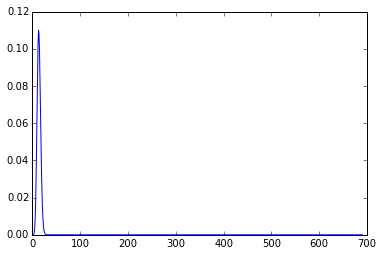

In [6]:
run_modeling(pc, params, 1)

Time elapsed 0.19994020462036133
E = 13.749999999999993, Var = 14.047500000000099


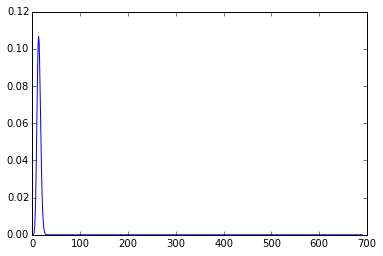

In [7]:
run_modeling(pc, params, 2)

When a and b are known:

For the first model let us define $x_1 = Bin(a, p_1)$ and $x_2 = Bin(b, p_2)$, then

$$ p(c | a, b) = p(x_1 + x_2 = c| a, b) = \sum_{i = 0}^c Bin(i | ap_1)Bin(c - i|bp_2) $$

For the second model we have:

$$ p(c | a, b) = Poison(ap_1 + bp_2) $$

In [8]:
def pc_ab(a, b, params, model):
    return pc_ab__(a, b, model, **params)

def pc_ab__(a, b, model, a_min, a_max, b_min, b_max, p1, p2, p3):
    c_space = np.arange(a_max + b_max + 1)

    if model == 1:
        p = np.convolve(sp.stats.binom.pmf(c_space, a, p1), sp.stats.binom.pmf(c_space, b, p2))

    elif model == 2:
        p = sp.stats.poisson.pmf(c_space, (a * p1 + b * p2))

    return p[:a_max + b_max + 1], c_space

Time elapsed 0.0012140274047851562
E = 13.800000000000345, Var = 12.914999999995672


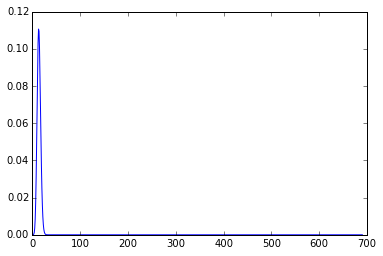

In [9]:
run_modeling(pc_ab, params, 1, 83, 550)

Time elapsed 0.00057220458984375
E = 13.800000000000013, Var = 13.79999999999987


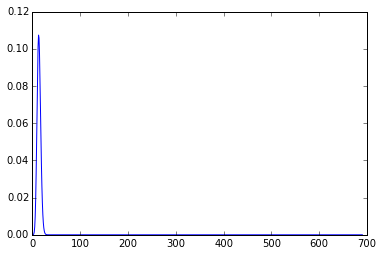

In [10]:
run_modeling(pc_ab, params, 2, 83, 550)

When a is known:

For both models we have:

$$ p(c | a) = \sum_{b} p(c | a,b) p(b) $$

When b is known:

For both models we have:

$$ p(c | b) = \sum_{a} p(c | a,b) p(a) $$

In [11]:
def pc_a(a, params, model):
    c_space = np.arange(params['a_max'] + params['b_max'] + 1)
    p = np.zeros(c_space.size)
    
    for b in range(params['b_min'], params['b_max'] + 1):
        p += pc_ab(a, b, params, model)[0]
        
    return p * p_uniform(params['b_min'], params['b_max']) , c_space

Time elapsed 0.0756838321685791
E = 13.799999999999898, Var = 13.000000000000995


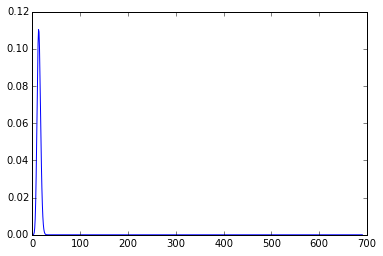

In [12]:
run_modeling(pc_a, params, 1, 83)

Time elapsed 0.030625104904174805
E = 13.79999999999999, Var = 13.885000000000161


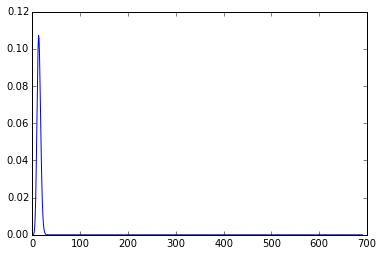

In [13]:
run_modeling(pc_a, params, 2, 83)

In [14]:
def pc_b(b, params, model):
    c_space = np.arange(params['a_max'] + params['b_max'] + 1)
    p = np.zeros(c_space.size)
    
    for a in range(params['a_min'], params['a_max'] + 1):
        p += pc_ab(a, b, params, model)[0]
        
    return p * p_uniform(params['a_min'], params['a_max']) , c_space

Time elapsed 0.014111042022705078
E = 13.750000000000348, Var = 13.082499999995775


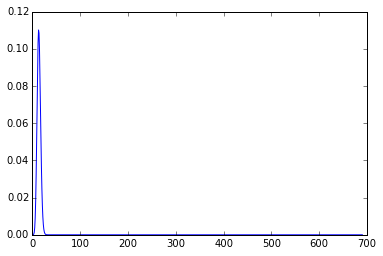

In [15]:
run_modeling(pc_b, params, 1, 550)

Time elapsed 0.00465703010559082
E = 13.749999999999988, Var = 13.96250000000012


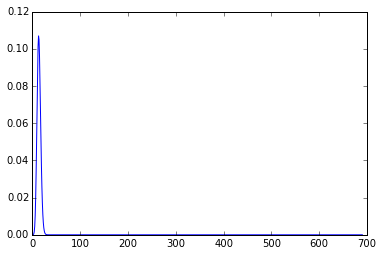

In [16]:
run_modeling(pc_b, params, 2, 550)

For d we have:

$$ p(d) = \sum_{c} p(d|c) p(c) $$

$$ p(d|c) = Pr[c + Bin(c, p3) = d ~ | ~ c] = Pr[Bin(c, p3) = d - c ~ | ~ c] $$

In [17]:
def pd(params, model):
    d_space = np.arange(2 * (params['a_max'] + params['b_max']) + 1)
    
    p_of_c, c_space = pc(params, model)
    
    d, c = np.meshgrid(d_space, c_space)
    
    p = sp.stats.binom.pmf(d - c, c, params['p3']).T.dot(p_of_c)
            
    return p, d_space

Time elapsed 0.1788339614868164
E = 17.874999999999872, Var = 25.140575000001718


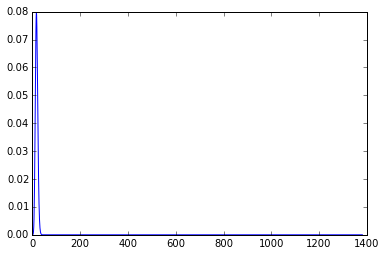

In [18]:
run_modeling(pd, params, 1)

Time elapsed 0.17160606384277344
E = 17.874999999999996, Var = 26.627774999999986


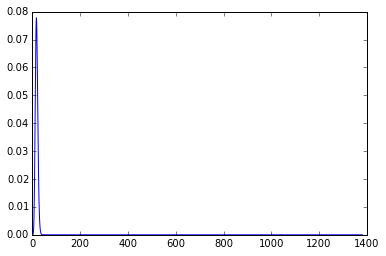

In [19]:
run_modeling(pd, params, 2)

For p(c|d) we have:
    
$$ p(c|d) = \frac{p(d|c)p(c)}{p(d)} $$

In [20]:
def pc_d(d, params, model):
    p_of_c, c_space = pc(params, model)
    
    p = sp.stats.binom.pmf(d - c_space, c_space, params['p3']) * p_of_c
    p = p / np.sum(p)
    
    return p, c_space

Time elapsed 0.0030879974365234375
E = 13.895970598988919, Var = 1.533581700672869


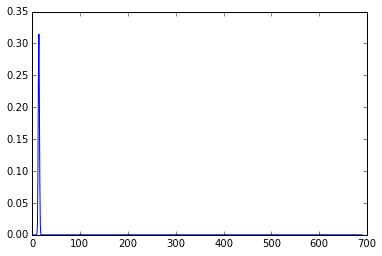

In [21]:
run_modeling(pc_d, params, 1, 18)

Time elapsed 0.0006110668182373047
E = 13.893833892236303, Var = 1.5439433290956117


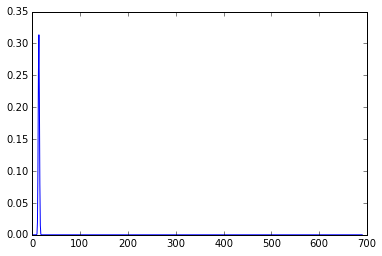

In [22]:
run_modeling(pc_d, params, 2, 18)

$$ p(c|a,b,d) = \frac{p(a,b,c,d)}{p(d|ab)p(ab)} = \frac{p(d|c)p(c|a,b)}{p(d|ab)} $$
$$ p(d|ab) = \sum_{c} p(d|c, a, b) p(c|a,b) = \sum_{c} p(d|c) p(c|a,b) $$

In [23]:
def pc_abd(a, b, d, params, model):
    p_of_c_ab, c_space = pc_ab(a, b, params, model)
    
    pd_c = sp.stats.binom.pmf(d - c_space, c_space, params['p3'])
    
    p = pd_c * p_of_c_ab / pd_c.dot(p_of_c_ab)

    return p, c_space

Time elapsed 0.002138853073120117
E = 11.146681111745641, Var = 1.2023782109538956


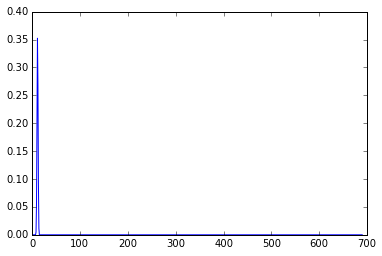

In [24]:
run_modeling(pc_abd, params, 1, 83, 550, 14)

Time elapsed 0.0011069774627685547
E = 11.127877449003964, Var = 1.2089770653692113


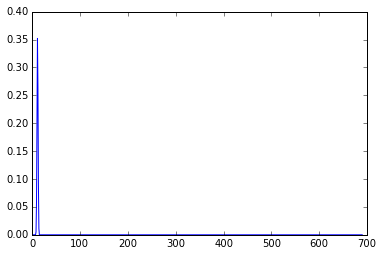

In [25]:
run_modeling(pc_abd, params, 2, 83, 550, 14)

Paramster d contributes most to improving of estimate c (in the sense of the variance of distribution).

In [26]:
def plot_variances(model):
    d_space = np.arange(2 * (params['a_max'] + params['b_max']) + 1)
    dc_d = np.zeros(d_space.size)
    dc_b = np.zeros(d_space.size)
    dc_a = np.zeros(d_space.size)

    for d in d_space:
        if d >= params['a_min'] and  d <= params['a_max'] + 1:
            vara = var(*pc_a(d, params, model))
        else:
            vara = 0

        if d >= params['b_min'] and  d <= params['b_max'] + 1:
            varb = var(*pc_b(d, params, model))
        else:
            varb = 0

        p_of_c_d, c_space = pc_d(d, params, model)
        vard = var(p_of_c_d, c_space) 

        dc_d[d] = vard
        dc_a[d] = vara
        dc_b[d] = varb

    plt.plot(dc_d, label='D[c|d]')
    plt.plot(dc_a, label='D[c|a]')
    plt.plot(dc_b, label='D[c|b]')
    plt.legend(loc='best')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


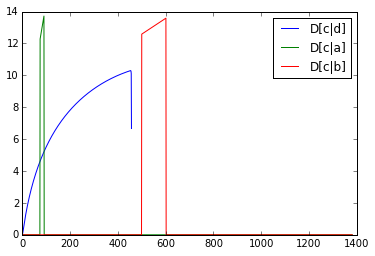

In [27]:
plot_variances(1)

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


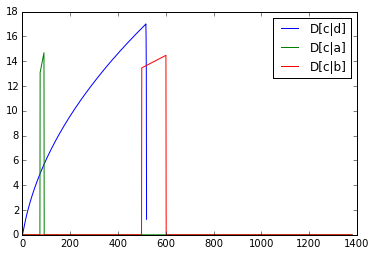

In [28]:
plot_variances(2)

The most significant things, that changes between models are execution time and variance. Regarding the variance, the maximum difference was obtained with the following conditions: p(c|ab). The difference betwen models in variance was about 0.885. The difference for conditions p(c|a), p(c|b), p(c) are very close from 0.83 up to 0.88.